# 121118
Going through the growth data to plot it.

In [22]:
#import packages

import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
%matplotlib inline

In [46]:
# Functions:
def to_min(s):
    hr, min, sec = [float(x) for x in s.split(':')]
    
    return hr*60 + min + sec/60

def convert_timestamp(ts):
    converted_time = []
    for stamp in ts:
        timeCalc = to_min(stamp)
        converted_time.append(timeCalc)
    
    return converted_time

def merge_dfs(df1, df2):
    """
    This function will combine the union of two dataframes based on their
    indices. Ordered based on first df. 
    """
    merged_df = pd.concat([df1, df2], axis=1, join_axes=[df1.index])
    
    return merged_df


def import_data(dateExpRun):
    """
    Assuming all the file names follow the correct pattern, extracts
    the data, and the conditions on the plate. Puts together a data
    frame containing all the data and condition info per well.
    
    Also outputs a list of all the timepoints (these are also
    the column names of the timepoints for the data)
    
    
    """
    growth_data_path = os.path.join(os.getcwd(), dateExpRun + '_DataOnly_OD700.txt')
    FITC_data_path = os.path.join(os.getcwd(), dateExpRun + '_DataOnly_FITC.txt')
    TRITC_data_path = os.path.join(os.getcwd(), dateExpRun + '_DataOnly_TRITC.txt')
    plate_path = os.path.join(os.getcwd(), dateExpRun + '_PlateLayout_2.txt')
    
    OD700_data_df = pd.read_csv(growth_data_path, sep = '\t').T
    FITC_data_df = pd.read_csv(FITC_data_path, sep = '\t').T
    TRITC_data_df = pd.read_csv(TRITC_data_path, sep = '\t').T
    plate_df= pd.read_csv(plate_path, sep = '\t').set_index('Well_Name')
    
    df_700 = merge_dfs(plate_df, OD700_data_df)
    FITC_df = merge_dfs(plate_df, FITC_data_df)
    TRITC_df = merge_dfs(plate_df, TRITC_data_df)
    
    timepoints = list(OD700_data_df)
    time = OD700_data_df.loc['Time'].tolist()
    
    return df_700, FITC_df, TRITC_df, timepoints, time

def get_treatments(df):
    """
    This function will pull out the pre-treatments, and treatments used in
    the experiment. Input is a dataframe. Output is two numpy arrays.
    The first one is pretreatments, second treatments.
    """
    celltype = np.unique(np.asarray(df['Cell_Type'].tolist()))
    treatment = np.unique(np.asarray(df['Treatment'].tolist()))
    
    #get rid of any nan strings.
    
    celltype = celltype[celltype!='nan']
    treatment = treatment[treatment!='nan']
    
    return celltype, treatment  

def get_conditional_ids(cell_type, treatment, df):
    """
    This helper function will the well name for a specific pretreatment and treatment.
    """
    #all_treat_ids = df.loc[(df.Treatment == treatment) & (df.Pre_Treatment == pre_treatment), 'Well_Name']
    all_treat_df = df.loc[(df['Cell_Type'] == cell_type) & (df['Treatment'] == treatment)]
    all_treat_idx = all_treat_df.index.tolist()
    
    return all_treat_idx

def group_conditional_ids(cell_type, treatment, df, timepoints):
    """
    This function will pull out all the well name of all matching pretreatment and treatment conditions 
    and data, as lists. The orders for all lists should match. 
    """
    grouped_wells = []
    grouped_names = []
    grouped_data = []
    for treatment in treatment:
        for ct in cell_type:
            well_ids = get_conditional_ids(ct, treatment, df)
            current_well_data = []
            for well_id in well_ids:
                current_well_data.append([df.get_value(well_id, timepoint) for timepoint in timepoints])
            grouped_wells.append(well_ids)
            grouped_names.append(str(ct) + '_' + str(treatment))
            grouped_data.append(current_well_data)

    return grouped_wells, grouped_names, grouped_data

def averageAllConditions(data):
    """
    
    """
    avg_group = []
    for dat in data:
        avg_group.append([averageSingleCondition(dat)])
        
    return avg_group

def averageSingleCondition(single_group_data):
    """
    single_group_data should be a list of lists containing all data
    that belongs to a single treatment group.
    """
    averaged_data = [sum(e)/len(e) for e in zip(*single_group_data)] 
    return averaged_data

def stdAllConditions(data):
    
    std_group = []
    for dat in data:
        std_group.append([stdSingleCondition(dat)])
    return std_group

def stdSingleCondition(single_group_data):
    """
    single_group_data should be a list of lists containing all data
    that belongs to a single treatment group.
    """
    std_data = []
    for e in zip(*single_group_data):
        cntN = len(e)
        avgVal = float(sum(e))/cntN
        std_data.append((sum((i-avgVal)**2 for i in e)/(cntN-1))**0.5)
    return std_data

def group_ids(grouped_ids):
    """
    
    """
    group_well_id = []
    for well_id in grouped_ids:
        if len(well_id) > 0:
            group_well_id.append(well_id[0])
        else:
            group_well_id.append('')
    
    return group_well_id

def gather_data_to_plot(wells, df):
    """
    Given a well ID, plot the associated data, pull out treatments.
    Pull in dataframe of all the data.
    """
    data_to_plot = []
    error_to_plot = []
    legend = []
    for well in wells:
        data_to_plot.append(df.loc[df['ID'] == well, 'Timecourse Data'].tolist())
        error_to_plot.append(df.loc[df['ID'] == well, 'STD'].tolist())
        legend.append(df.loc[df['ID'] == well, 'Treatment'].tolist())
    return data_to_plot, error_to_plot, legend


def fetch_all_data(ds_df, timepoints, timestamp):
    #ds_df, timepoints, data_df, timestamp = import_data(date_exp_run)
    cell_type, treat = get_treatments(ds_df)
    grouped_well_id, grouped_well_names, grouped_data = group_conditional_ids(cell_type, treat, ds_df, timepoints)
    grouped_averaged_data = averageAllConditions(grouped_data)
    grouped_averaged_ids = group_ids(grouped_well_id)
    averaged_data_std = stdAllConditions(grouped_data)
    print(len(grouped_averaged_ids), len(grouped_well_names),
          len(grouped_averaged_data), len(averaged_data_std))
    df = pd.DataFrame(np.column_stack([grouped_averaged_ids, grouped_well_names, grouped_averaged_data, 
                                       averaged_data_std]), columns=['ID', 'Treatment', 
                                                                     'Timecourse Data', 'STD']).sort_values(['ID'])
    time = convert_timestamp(timestamp)
    
    return df, time

def calculate_lag(cond_1, cond_2, df, time, OD):
    """
    Condition 2 is the lagging condition, while condition 1 is the quicker one.
    """
    w_to_comp = [cond_1, cond_2]
    time_to_od = cal_time_to_od(w_to_comp, df, time, OD)
    lag = time_to_od[1] - time_to_od[0]

    return lag

def cal_time_to_od(w_to_comp, df, time, OD):
    ind = []
    time_to_od = []
    for well in w_to_comp:
        wd = df.loc[df['ID'] == well, 'Timecourse Data'].tolist()[0]
        current_ind = next((i for i, x in enumerate(wd) if x > OD), -1)
        ind.append(current_ind)
        time_to_od.append(time[current_ind])
    return time_to_od




In [75]:
def fetch_all_data_Cur(date_exp_run, df_channel, timepoints, timestamp):
    #ds_df, timepoints, data_df, timestamp = import_data(date_exp_run)
    cell_type, treat = get_treatments(df_channel)
    grouped_well_id, grouped_well_names, grouped_data = group_conditional_ids(cell_type, treat, df_channel, timepoints)
    grouped_averaged_data = averageAllConditions(grouped_data)
    averaged_stds = stdAllConditions(grouped_data)
    
    grouped_well_id_arr = np.zeros((len(grouped_well_id)), dtype=object)
    for i in range(len(grouped_well_id)):
        grouped_well_id_arr[i] = grouped_well_id[i][0]

    grouped_well_names_arr = np.zeros((len(grouped_well_names)), dtype=object)
    for i in range(len(grouped_well_names)):
        grouped_well_names_arr[i] = grouped_well_names[i]
        
    grouped_data_arr = np.zeros((len(grouped_averaged_data)), dtype=object)
    for i in range(len(grouped_averaged_data)):
        grouped_data_arr[i] = grouped_averaged_data[i][0]
        
    grouped_std_arr = np.zeros((len(averaged_stds)), dtype=object)
    for i in range(len(averaged_stds)):
        grouped_std_arr[i] = averaged_stds[i][0]


    df = pd.DataFrame(np.column_stack([grouped_well_id_arr, grouped_well_names_arr, grouped_data_arr, grouped_std_arr]), 
                  columns=['ID', 'Treatment', 'Timecourse Data', 'STD']).sort_values(['ID'])

    
    time = convert_timestamp(timestamp)
    return df, time

In [61]:
date_exp_run = '120518'

In [69]:
OD700_data_df, FITC_data_df, TRITC_data_df, timepoints, timestamp = import_data(date_exp_run)
df_700, time = fetch_all_data_Cur(date_exp_run, OD700_data_df, timepoints, timestamp)
df_FITC, time = fetch_all_data_Cur(date_exp_run, FITC_data_df, timepoints, timestamp)
df_TRITC, time = fetch_all_data_Cur(date_exp_run, TRITC_data_df, timepoints, timestamp)

In [70]:
df_700

,ID,Treatment,Timecourse Data,STD
1,A1,MG1655_Glucose,"[0.098, 0.10475, 0.105, 0.1045, 0.1075, 0.1125...","[0.006055300708194982, 0.007041543391425874, 0..."
17,A10,dLacZA_LacZ_Linker_1_mClover_Lactose,"[0.09050000000000001, 0.09100000000000001, 0.0...","[0.0023804761428476155, 0.0029439202887759468,..."
15,A11,dLacYA_LacY_Linker_2_mKate_Lactose,"[0.092, 0.09275, 0.093, 0.09425000000000001, 0...","[0.0020000000000000018, 0.0015000000000000013,..."
13,A12,dLacYA_LacY_Lactose,"[0.08925000000000001, 0.08975, 0.0905, 0.09125...","[0.0004999999999999935, 0.0004999999999999935,..."
9,A2,delZA_Glucose,"[0.08975, 0.09125, 0.09250000000000001, 0.0947...","[0.0009574271077563317, 0.000957427107756339, ..."
10,A3,delZYA_Glucose,"[0.09, 0.09175, 0.09375, 0.0955, 0.09725, 0.09...","[0.0008164965809277211, 0.0012583057392117972,..."
6,A4,dLacZA_LacZ_Linker_1_mClover_Glucose,"[0.08975, 0.09075, 0.09125, 0.09325, 0.095, 0....","[0.0018929694486000928, 0.001892969448600086, ..."
4,A5,dLacYA_LacY_Linker_2_mKate_Glucose,"[0.09225, 0.0925, 0.09375, 0.0955, 0.09725, 0....","[0.0018929694486000928, 0.0012909944487358084,..."
2,A6,dLacYA_LacY_Glucose,"[0.08950000000000001, 0.09025000000000001, 0.0...","[0.0005773502691896182, 0.0014999999999999935,..."
12,A7,MG1655_Lactose,"[0.09125, 0.09175, 0.09175, 0.0935, 0.09325, 0...","[0.0028722813232690096, 0.00309569593683445, 0..."


### Plot Data for Specific Wells

In [71]:
well_treat = ['Glucose', 'Lactose']

In [74]:
#Conditions to plot together:


controls_condensed = [['A1', 'E1', 'A2', 'E2', 'A3'], #Glucose
                      ['A7', 'E7', 'A8', 'E8', 'A9']] #Lactose
del_ZA_condensed = [['A4', 'E3', 'E4'], 
                    ['A10', 'E9', 'E10']]
del_YA_condensed = [['A5', 'A6', 'E5'], 
                    ['A11', 'A12', 'E11']]

del_ZA = [['A4', 'C4', 'E3', 'E4', 'G3', 'G4'], 
          ['A10', 'C10', 'E9', 'E10', 'G9', 'H10']]
del_YA = [['A5', 'A6', 'C5', 'C6', 'E5', 'G5'], 
          ['A11', 'A12', 'C11', 'C12', 'E11', 'F11']]
#del_ZYA = [['D5', 'F5'], ['D11', 'F11']]
 
conditions = [controls_condensed, del_ZA_condensed, del_YA_condensed]
condition_names = ['controls','del_ZA', 'del_YA']

dfs = [df_700, df_FITC, df_TRITC]
limits = [[0, 0.7], [0, 80000], [0,1200]]
plt_name = ['OD700', 'FITC', 'TRITC']


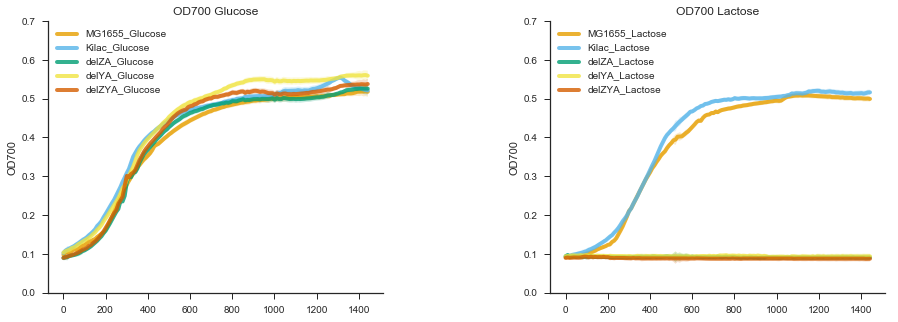

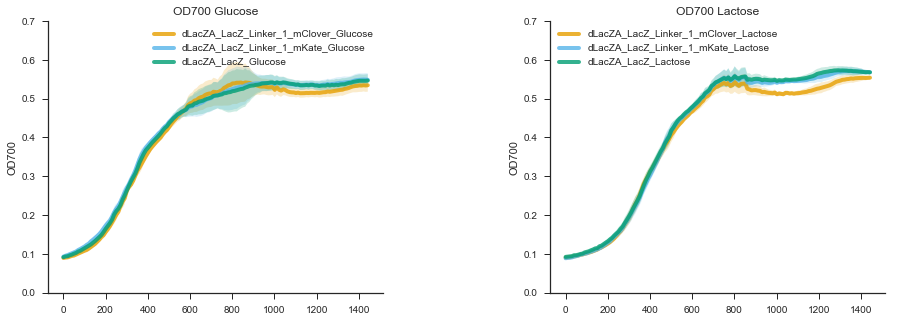

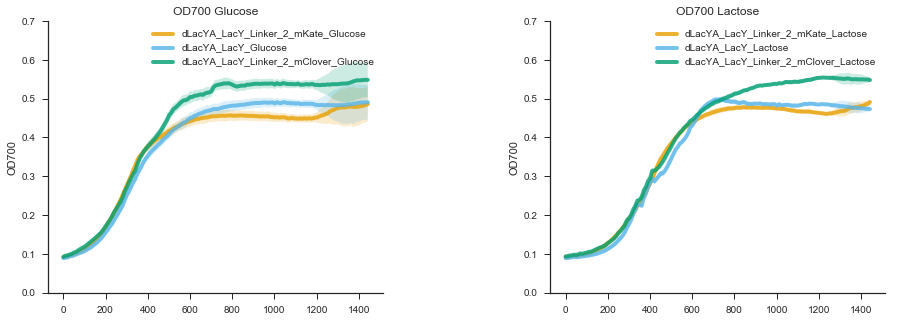

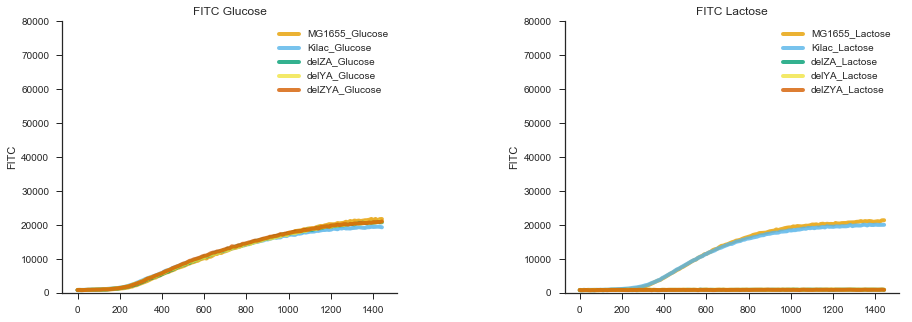

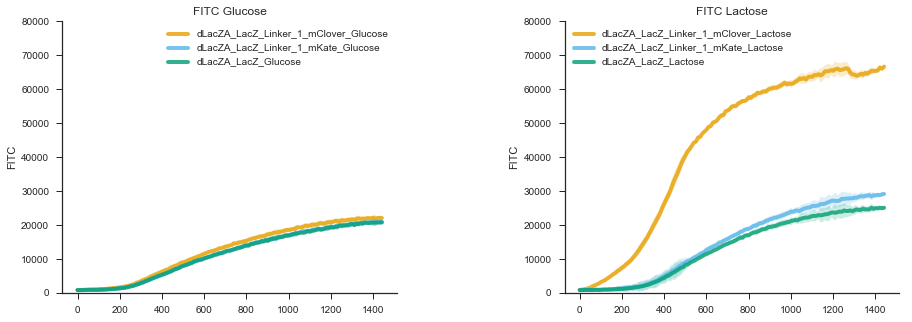

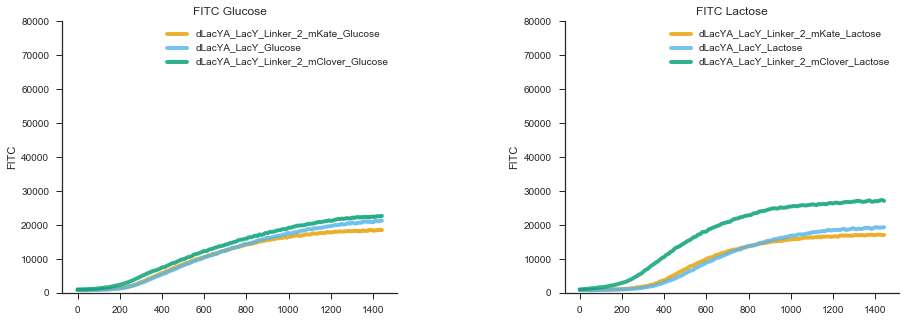

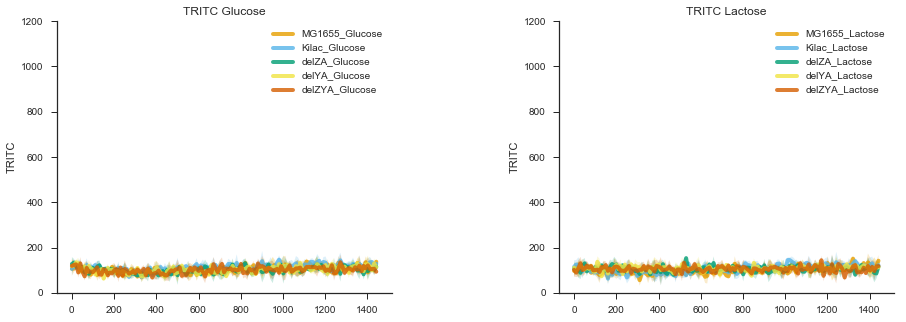

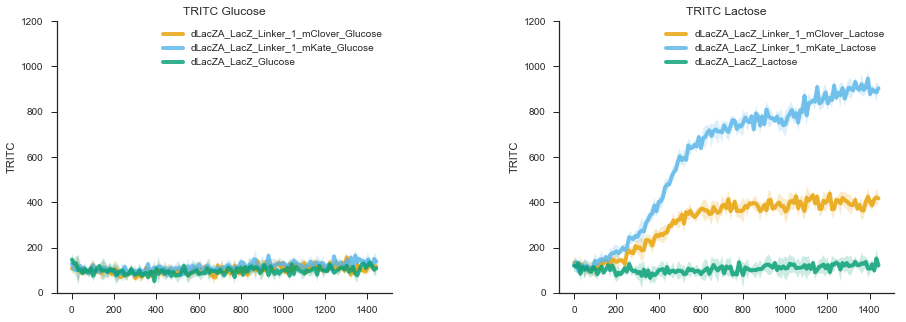

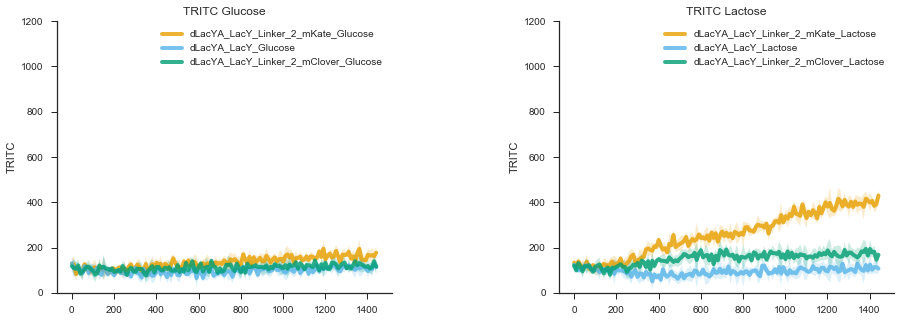

In [73]:
num = 0
for df in dfs:
    for j in range(len(conditions)):
        #fig.clf()
        fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.5)
        sns.set_style('ticks')
        #color_palette = ['k', '#e69f00','#56b4e9', '#009e73', '#f0e442', '#0072b2', '#d55e00', '#cc79a7']
        color_palette = ['#e69f00','#56b4e9', '#009e73', '#f0e442', '#d55e00', '#cc79a7']
        for i in range(len(conditions[j])):
            data_to_plot, error_to_plot, legendName = gather_data_to_plot(conditions[j][i], df)
            c = 0
            for data in data_to_plot:
                time_x = time[:]
                data_y = data[0][:]
                error = error_to_plot[0][:][0]
                axs[i].set_title(plt_name[num] + ' ' + well_treat[i])
                axs[i].plot(time_x, data_y,  color = color_palette[c], linewidth = 4, alpha = .8, label = legendName[c][0])
                axs[i].fill_between(np.array(time_x), np.array(data_y)- np.array(error), 
                                    np.array(data_y) + np.array(error), alpha=0.20, facecolor = color_palette[c])
                axs[i].legend()
                axs[i].set_ylim(limits[num])
                axs[i].set_ylabel(plt_name[num])
                c += 1
            sns.despine()
        fig.savefig(plt_name[num] + condition_names[j] + '.pdf', bbox_inches='tight')
        fig.savefig(plt_name[num] + condition_names[j] + '.png', bbox_inches='tight')
    num += 1